In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')

Populating the interactive namespace from numpy and matplotlib


In [3]:
data = pd.read_excel('data/clean_data.csv')
data.shape

### Credit_TermApr vs MA_Proposed_Term

Для многих значения разница между этими признакми равна в 1 месяц. 

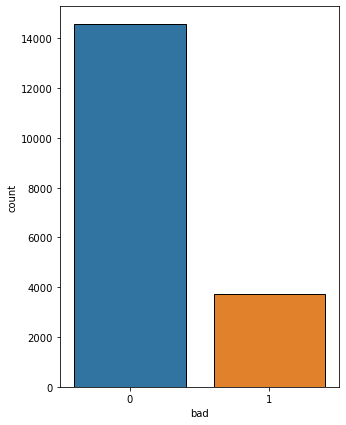

In [9]:
plt.figure(figsize=(5,7))
sns.countplot(x=data['bad'], edgecolor='k')
plt.show()